# Setup

In [1]:
import pymongo
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import timedelta
from iso8601 import parse_date

sns.set_theme(style="darkgrid")

season_start = parse_date("2018-08-26T09:56:48.142Z") - timedelta(minutes=30)
season_end = parse_date("2018-09-30T00:11:58.716Z") + timedelta(minutes=30)

client = pymongo.MongoClient()
db = client.tpp3
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}})
data = pd.DataFrame(list(collection))
keys = list(data.keys())
to_drop = ["game","avatars","teams","base_metagames","base_gimmicks"]
for i in to_drop:
    if i in keys:
        data = data.drop([i], axis=1)

data.result = pd.to_numeric(data.result, errors="coerce")

data["duration"] = data.finished_at - data.started_at
data = data.drop(["started_at","finished_at","created_at"],axis=1)

data[["odds","blue_odds"]] = pd.DataFrame(data.pokeyen_odds.to_list(), index=data.index)
data["winner_odds"] = [data.odds[i] if result==1 else data.blue_odds[i] for i,result in enumerate(data["result"])]
data = data.drop(["pokeyen_odds","blue_odds"],axis=1)

data["num_bettors"] = data.pokeyen_bets.str.len() # magic I guess
data = data.drop(["pokeyen_bets"], axis=1)

# TODO there has to be a better way
average_bet = []
total_bonus = []
collection = db.matches.find({"finished_at": {"$gt": season_start, "$lt": season_end}}) # it broke without resetting collection here
for i, match in enumerate(collection):
    average_bet.append(0.0 if len(match["pokeyen_bets"]) == 0
        else statistics.mean(v["amount"] for v in match["pokeyen_bets"].values()))
    if "bet_bonus" in match["pokeyen_bets"]:
        total_bonus.append(0.0 if len(match["pokeyen_bets"]) == 0 or match["result"] == None
            else (sum(bet["amount"]*bet["bet_bonus"]/100 for bet in match["pokeyen_bets"].values() if bet["team"] == match["result"])))
data["average_bet"] = pd.DataFrame(average_bet)
if len(total_bonus) > 0:
    data["bet_bonus_amount"] = pd.DataFrame(total_bonus)
del average_bet

keys = list(data.keys())
nonzero_bets = data[data.average_bet > 0]

data.info()
data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4662 entries, 0 to 4661
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype          
---  ------            --------------  -----          
 0   _id               4662 non-null   int64          
 1   result            4599 non-null   float64        
 2   stage             4662 non-null   object         
 3   gimmick           4662 non-null   object         
 4   switching         4662 non-null   object         
 5   custom            4662 non-null   bool           
 6   result_overrides  5 non-null      object         
 7   duration          4662 non-null   timedelta64[ns]
 8   odds              4662 non-null   float64        
 9   winner_odds       4662 non-null   float64        
 10  num_bettors       4662 non-null   int64          
 11  average_bet       4662 non-null   float64        
dtypes: bool(1), float64(4), int64(2), object(4), timedelta64[ns](1)
memory usage: 405.3+ KB


,_id,result,stage,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet
0,89522,0.0,stargazer,pinpoint,always,False,NaN,0 days 00:05:44.285000,1.752527,0.570604,32,782.750000
1,89523,1.0,sunny_park,normal,never,False,NaN,0 days 00:03:43.522000,1.631148,1.631148,35,834.600000
2,89524,1.0,sunset,rngod,never,True,NaN,0 days 00:05:53.706000,7.833438,7.833438,39,1083.794872
3,89525,0.0,sunset,secrecy,never,False,NaN,0 days 00:05:12.451000,0.463792,2.156139,40,735.775000
4,89526,1.0,sunny_park,adaptable,never,False,NaN,0 days 00:06:00.922000,0.333688,0.333688,39,836.153846
...,...,...,...,...,...,...,...,...,...,...,...,...
4657,94187,0.0,gateway,normal,never,False,NaN,0 days 00:07:10.350000,1.027310,0.973416,32,50926.218750
4658,94188,0.0,magma,normal,never,False,NaN,0 days 00:04:52.756000,0.278301,3.593226,29,49040.448276
4659,94189,1.0,lagoon,s2_defiance_and_random_order,never,False,NaN,0 days 00:06:26.925000,0.750986,0.750986,37,81750.108108
4660,94190,1.0,stargazer,traitor,always,False,NaN,0 days 00:06:28.584000,0.382239,0.382239,40,95974.400000


# Highlights 

### Match with the least bidders

In [2]:
data[data.num_bettors == data.num_bettors.min()]

,_id,result,stage,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet
614,90136,0.0,neon,combo_of_2,never,True,NaN,0 days 00:08:04.212000,1.000000e-30,1.000000e-30,0,0.0
615,90137,0.0,lagoon,normal,always,False,NaN,0 days 00:04:52.497000,1.000000e-30,1.000000e-30,0,0.0
616,90138,1.0,gateway,defiance,never,False,NaN,0 days 00:03:15.078000,1.000000e-30,1.000000e-30,0,0.0
642,90165,0.0,crystal,sketchy,never,False,NaN,0 days 00:07:51.082000,1.000000e-30,1.000000e-30,0,0.0
643,90166,1.0,stargazer,combo_of_2,never,True,NaN,0 days 00:03:44.479000,1.000000e-30,1.000000e-30,0,0.0
644,90167,1.0,sunny_park,normal,always,False,NaN,0 days 00:03:44.311000,1.000000e-30,1.000000e-30,0,0.0
645,90168,0.0,waterfall,normal,always,False,NaN,0 days 00:07:09.980000,1.000000e-30,1.000000e-30,0,0.0
2385,91914,1.0,sunset,blind_bet,never,True,NaN,0 days 00:04:43.016000,1.000000e-30,1.000000e-30,0,0.0
2386,91915,1.0,magma,chameleon,never,False,NaN,0 days 00:09:31.232000,1.000000e-30,1.000000e-30,0,0.0
2387,91916,0.0,sunset,normal,never,False,NaN,0 days 00:14:05.691000,1.000000e-30,1.000000e-30,0,0.0


### Match with the lowest average bet

In [3]:
data[data.average_bet == data.average_bet.min()]

,_id,result,stage,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet
614,90136,0.0,neon,combo_of_2,never,True,NaN,0 days 00:08:04.212000,1.000000e-30,1.000000e-30,0,0.0
615,90137,0.0,lagoon,normal,always,False,NaN,0 days 00:04:52.497000,1.000000e-30,1.000000e-30,0,0.0
616,90138,1.0,gateway,defiance,never,False,NaN,0 days 00:03:15.078000,1.000000e-30,1.000000e-30,0,0.0
642,90165,0.0,crystal,sketchy,never,False,NaN,0 days 00:07:51.082000,1.000000e-30,1.000000e-30,0,0.0
643,90166,1.0,stargazer,combo_of_2,never,True,NaN,0 days 00:03:44.479000,1.000000e-30,1.000000e-30,0,0.0
644,90167,1.0,sunny_park,normal,always,False,NaN,0 days 00:03:44.311000,1.000000e-30,1.000000e-30,0,0.0
645,90168,0.0,waterfall,normal,always,False,NaN,0 days 00:07:09.980000,1.000000e-30,1.000000e-30,0,0.0
2385,91914,1.0,sunset,blind_bet,never,True,NaN,0 days 00:04:43.016000,1.000000e-30,1.000000e-30,0,0.0
2386,91915,1.0,magma,chameleon,never,False,NaN,0 days 00:09:31.232000,1.000000e-30,1.000000e-30,0,0.0
2387,91916,0.0,sunset,normal,never,False,NaN,0 days 00:14:05.691000,1.000000e-30,1.000000e-30,0,0.0


### Match with the lowest Red odds

In [4]:
data[data.odds == data.odds.max()]

,_id,result,stage,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet
4251,93781,1.0,main_street,normal,never,True,NaN,0 days 00:04:34.695000,264464.182738,264464.182738,32,1.551254e+07


### Match with the most bidders

In [5]:
data[data.num_bettors == data.num_bettors.max()]

,_id,result,stage,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet
45,89567,0.0,crystal,pinpoint,always,False,NaN,0 days 00:02:48.028000,0.382807,2.612285,55,1809.163636
69,89591,1.0,gateway,normal,always,False,NaN,0 days 00:05:07.471000,1.171386,1.171386,55,773.763636


### Match with the highest average bet

In [6]:
data[data.average_bet == data.average_bet.max()]

,_id,result,stage,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet
4434,93964,0.0,sunset,normal,never,False,NaN,0 days 00:07:37.749000,0.000008,118197.482293,14,4.934787e+07


### Match with the highest red odds

In [7]:
data[data.odds == data.odds.min()]

,_id,result,stage,gimmick,switching,custom,result_overrides,duration,odds,winner_odds,num_bettors,average_bet
614,90136,0.0,neon,combo_of_2,never,True,NaN,0 days 00:08:04.212000,1.000000e-30,1.000000e-30,0,0.0
615,90137,0.0,lagoon,normal,always,False,NaN,0 days 00:04:52.497000,1.000000e-30,1.000000e-30,0,0.0
616,90138,1.0,gateway,defiance,never,False,NaN,0 days 00:03:15.078000,1.000000e-30,1.000000e-30,0,0.0
642,90165,0.0,crystal,sketchy,never,False,NaN,0 days 00:07:51.082000,1.000000e-30,1.000000e-30,0,0.0
643,90166,1.0,stargazer,combo_of_2,never,True,NaN,0 days 00:03:44.479000,1.000000e-30,1.000000e-30,0,0.0
644,90167,1.0,sunny_park,normal,always,False,NaN,0 days 00:03:44.311000,1.000000e-30,1.000000e-30,0,0.0
645,90168,0.0,waterfall,normal,always,False,NaN,0 days 00:07:09.980000,1.000000e-30,1.000000e-30,0,0.0
2385,91914,1.0,sunset,blind_bet,never,True,NaN,0 days 00:04:43.016000,1.000000e-30,1.000000e-30,0,0.0
2386,91915,1.0,magma,chameleon,never,False,NaN,0 days 00:09:31.232000,1.000000e-30,1.000000e-30,0,0.0
2387,91916,0.0,sunset,normal,never,False,NaN,0 days 00:14:05.691000,1.000000e-30,1.000000e-30,0,0.0


# Data over time

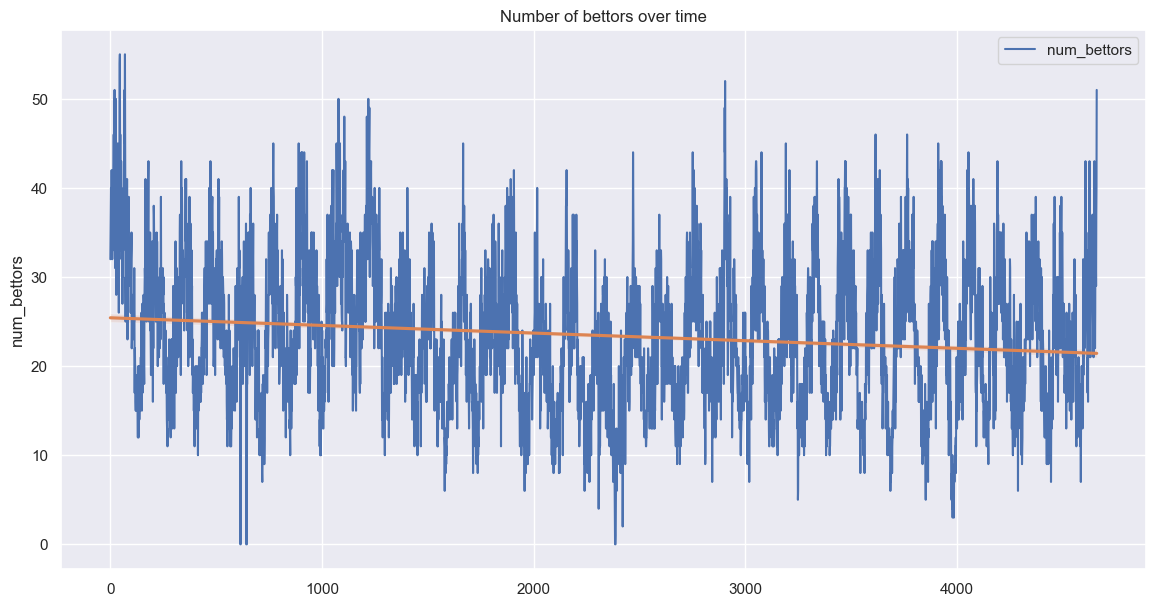

In [8]:
ax = data.plot(y="num_bettors",figsize=(14,7), title="Number of bettors over time")
sns.regplot(x=data.index, y=data.num_bettors, scatter=False, ax=ax)
# sns.kdeplot(y=data.num_bettors)
plt.show()

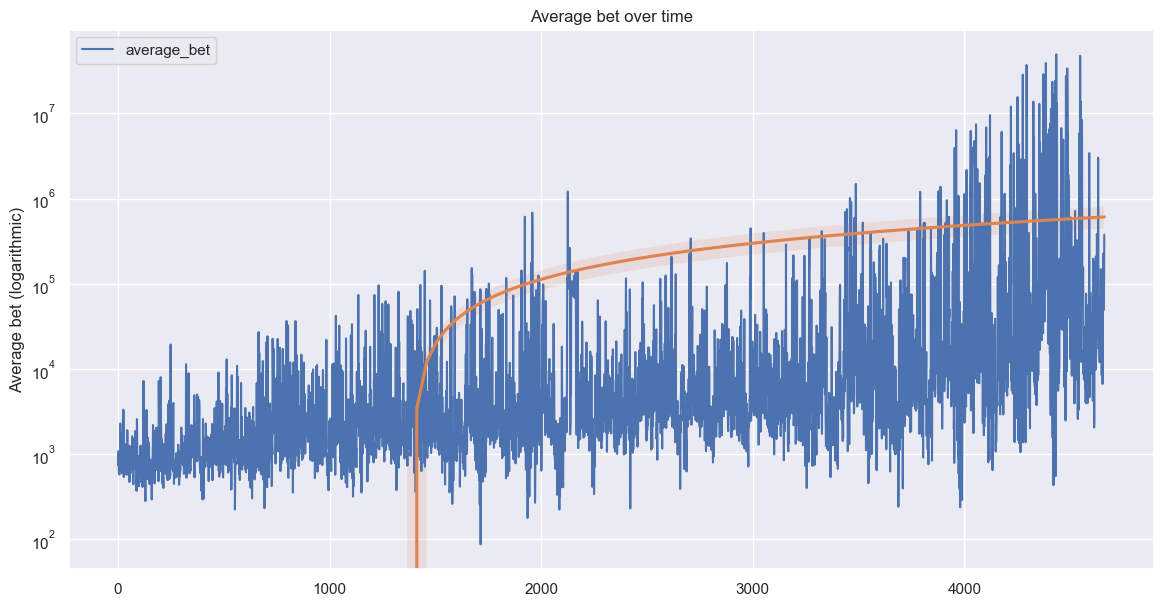

In [9]:
ax = nonzero_bets.plot(y="average_bet", logy=True, figsize=(14,7), title="Average bet over time")
sns.regplot(x=nonzero_bets.index, y=nonzero_bets.average_bet, scatter=False, ax=ax)
ax.set(ylabel="Average bet (logarithmic)")
plt.show()

<Figure size 640x480 with 0 Axes>

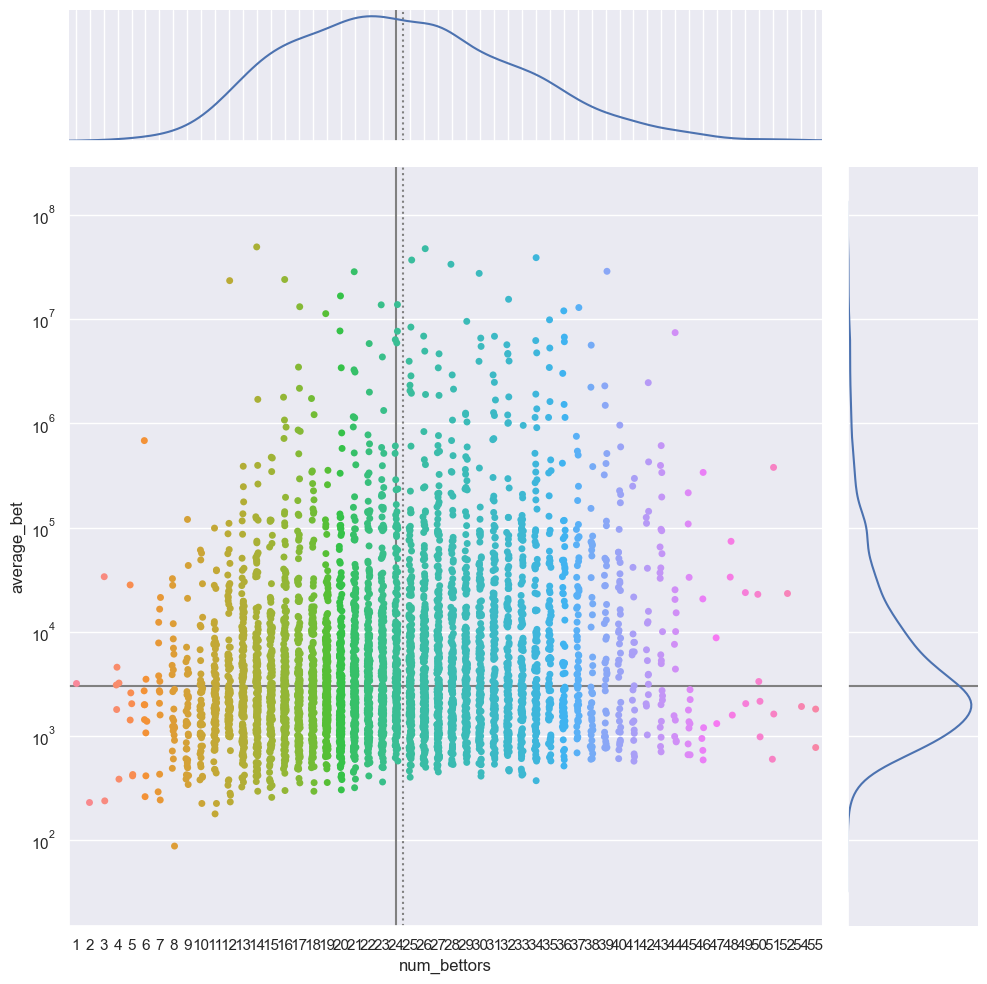

<Figure size 640x480 with 0 Axes>

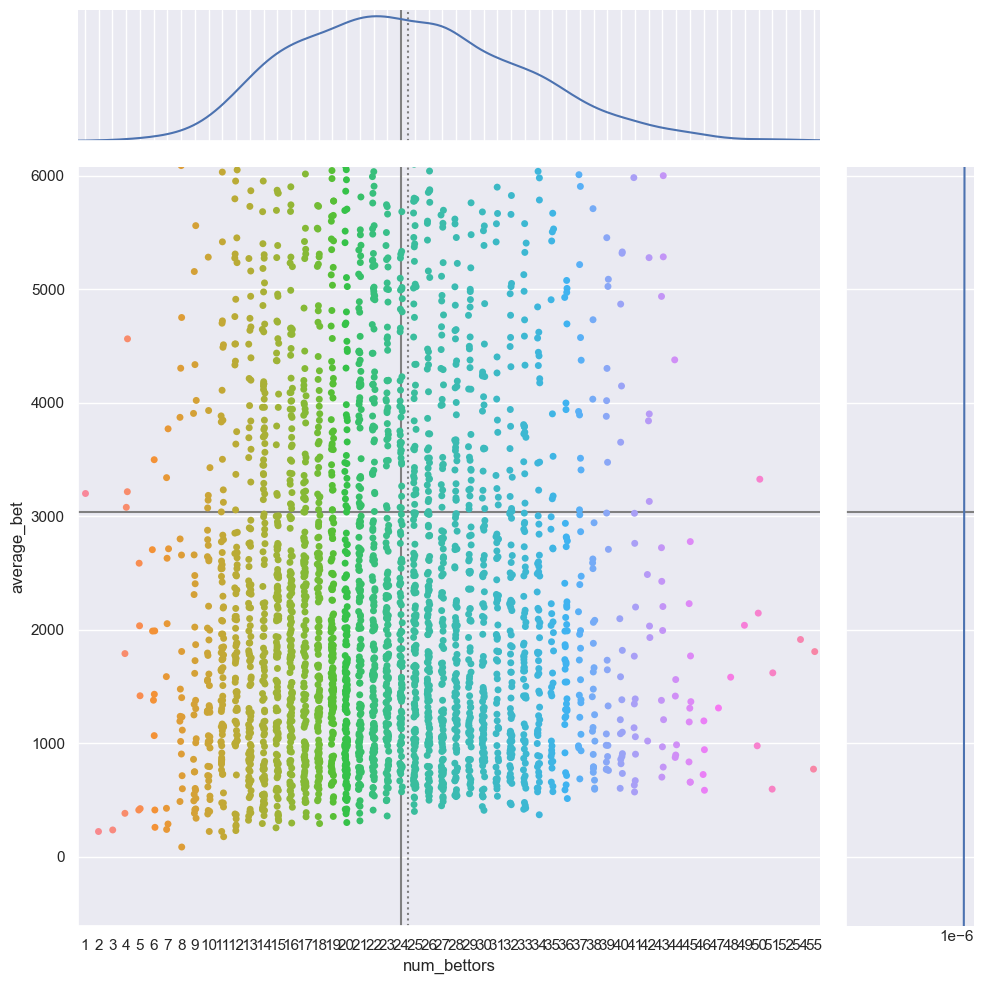

In [10]:
def fill_plot():
    g.refline(x=x.mean(), linestyle=":")
    g.refline(x=x.median(), y=y.median(), linestyle="-")
    sns.stripplot(x=x, y=y, s=5, ax=g.ax_joint)
    sns.kdeplot(x=x, ax=g.ax_marg_x)
    sns.kdeplot(y=y, ax=g.ax_marg_y)
    plt.xticks(rotation=90)
    
x, y = nonzero_bets.num_bettors, nonzero_bets.average_bet

f = plt.figure()
g = sns.JointGrid(x=x, y=y,
                   xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                   height=10,
                  )
g.ax_joint.set_yscale("log")
fill_plot()

median_thresh = y.median() * 2
if(y.max() > median_thresh * 10):
    f = plt.figure()
    g = sns.JointGrid(x=x, y=y,
                    xlim=(nonzero_bets.num_bettors.min()-1,nonzero_bets.num_bettors.max()+1),
                    height=10,
                    ylim=((-0.1*median_thresh),median_thresh)
                  )
    fill_plot()

plt.show()

In [11]:
if "metagame" in keys:
    f = plt.figure(figsize=(10,7))
    f.suptitle("When each metagame was played")
    ax = sns.scatterplot(x=data.index,y=data.metagame)
    ax.set(xlabel="Match #")
    plt.show()
else:
    print("No metagames this season :(")

No metagames this season :(


# Metagames

## Setup

In [12]:
if "metagame" in keys:
    threshold = 0.005 * data.index.max() # remove metagames that appear less than this amount of times, since they are likely token matches
    meta = nonzero_bets[nonzero_bets.groupby("metagame").metagame.transform("count") > threshold]
    metagames = nonzero_bets.metagame.unique().tolist()
    for m in meta.metagame.unique().tolist():
        metagames.remove(m)
    print("removed very rare metagames: " + str(metagames))

In [13]:
if "metagame" in keys:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
    f.suptitle("Number of people betting on each metagame")
    sns.boxplot(x=meta.metagame, y=meta.num_bettors)
    plt.xticks(rotation=90)
    plt.show()

In [14]:
if "metagame" in keys:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2.5,5))
    f.suptitle("Average bet on each metagame")
    ax = sns.boxplot(x=meta.metagame,y=meta.average_bet)
    ax.set(yscale="log", ylabel="Average bet (logarithmic)")
    plt.xticks(rotation=90)
    plt.show()

# Gimmicks

## Setup

In [15]:
if "gimmick" in keys:
    threshold_gim = 5 # absolute minimum amount of data we need to make any meaningful insight
    gim = nonzero_bets[nonzero_bets.groupby("gimmick").gimmick.transform("count") > threshold_gim]
    gimmicks = data.gimmick.unique().tolist()
    for g in gim.gimmick.unique().tolist():
        gimmicks.remove(g)
    print("removed infrequently used gimmicks: " + str(gimmicks))
else:
    print("no gimmicks this season :(")

removed infrequently used gimmicks: ['letdown', 'boing']


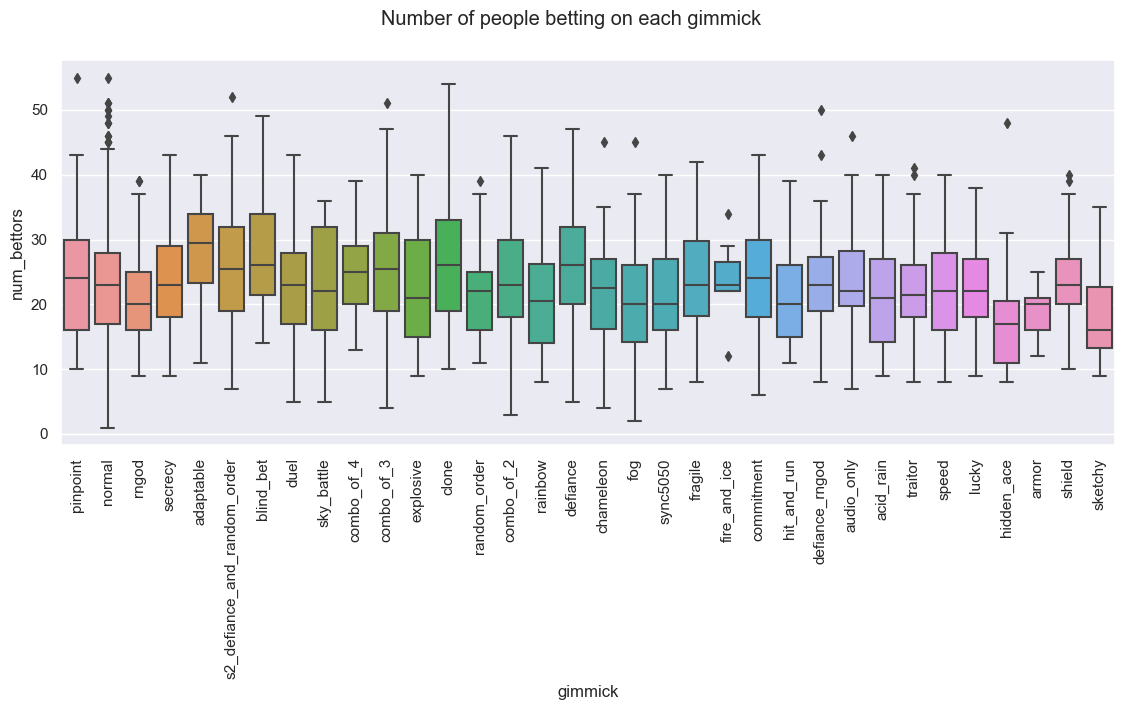

In [16]:
if "gimmick" in keys:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Number of people betting on each gimmick")
    sns.boxplot(x="gimmick",y="num_bettors",data=gim)
    plt.xticks(rotation=90)
    plt.show()

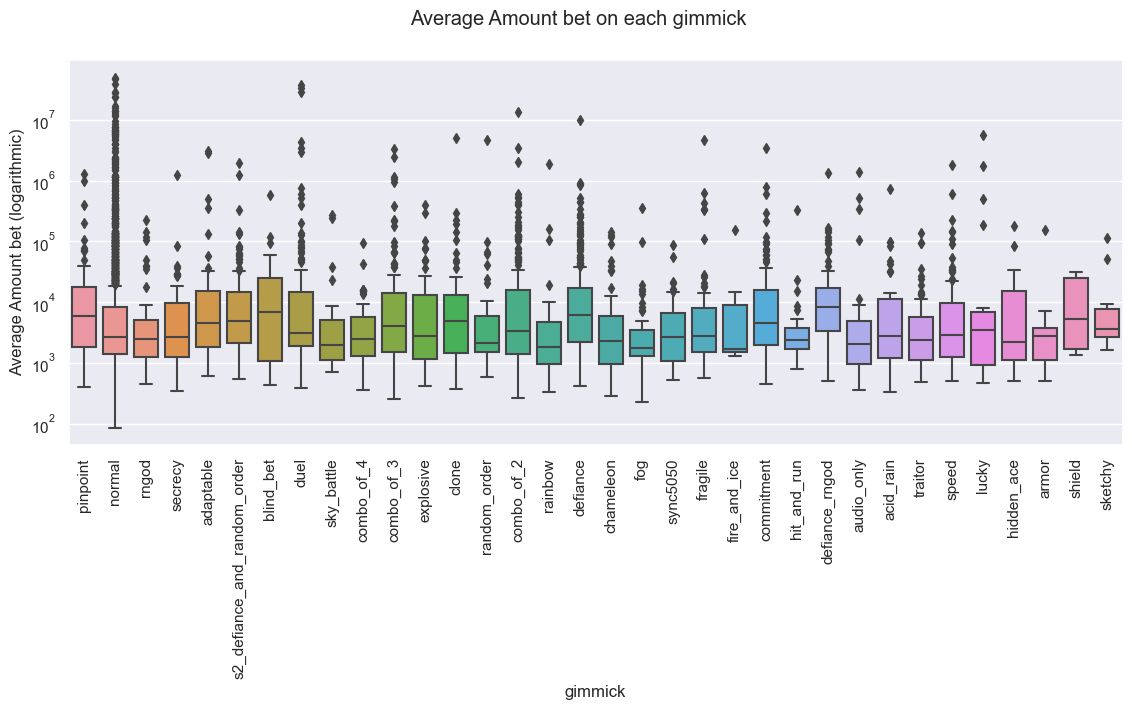

In [17]:
if "gimmick" in keys:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Average Amount bet on each gimmick")
    ax = sns.boxplot(x=gim.gimmick, y=gim.average_bet)
    ax.set(yscale="log", ylabel="Average Amount bet (logarithmic)")
    plt.xticks(rotation=90)
    plt.show()

# Switching

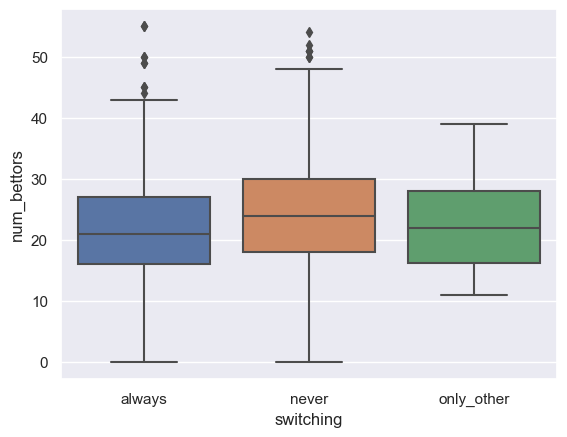

In [18]:
sns.boxplot(x=data.switching,y=data.num_bettors)
plt.show()

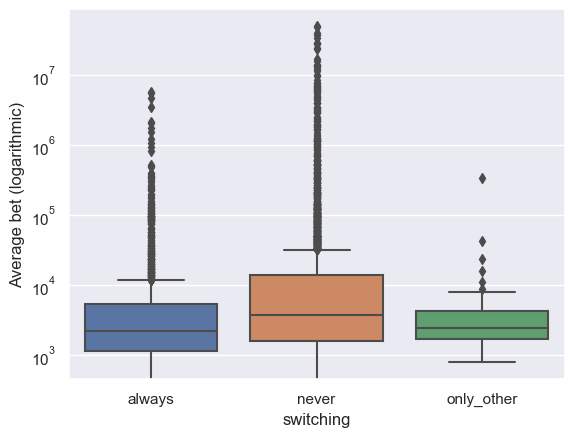

In [19]:
ax = sns.boxplot(x=data.switching,y=data.average_bet)
ax.set(yscale="log", ylabel="Average bet (logarithmic)")
plt.show()

# Odds vs winner
lower odds(<1) indicate more people bet on team 0 (probably red?), while higher(>1) odds indicate more people bet on team 1 (probably blue) 

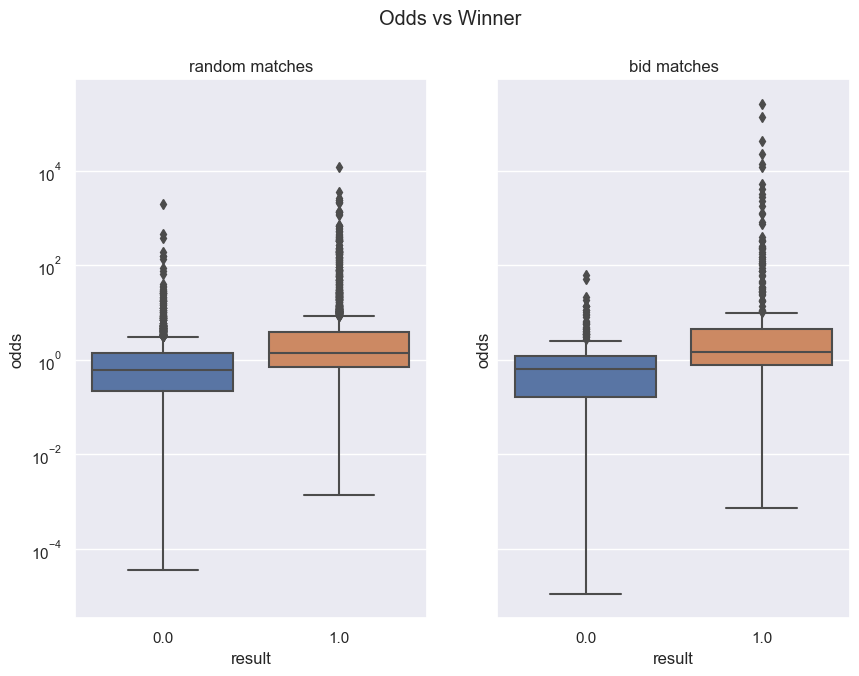

In [20]:
# remove entries where bets are all on 1 team
nonzero_bets = nonzero_bets[nonzero_bets.odds > 0.00001]

auto_matches = nonzero_bets[nonzero_bets.custom == False]
bid_matches = nonzero_bets[nonzero_bets.custom == True]

f, ax = plt.subplots(1, 2, figsize=(10,7),sharey=True)
f.suptitle("Odds vs Winner")
ax[0].set(yscale="log", title="random matches")
ax[1].set(title="bid matches")

sns.boxplot(x=auto_matches.result,y=auto_matches.odds, ax=ax[0])
sns.boxplot(x=bid_matches.result,y=bid_matches.odds)

plt.show()

# Bet bonus

In [21]:
if "bet_bonus_amount" in keys:
    should_draw_random_graph = auto_matches.bet_bonus_amount.mean() > 0
    should_draw_custom_graph = bid_matches.bet_bonus_amount.mean() > 0
    graphs_to_draw = should_draw_random_graph + should_draw_custom_graph
    i = 0

    f, ax = plt.subplots(graphs_to_draw, 1, figsize=(10,7),sharey=True)
    f.suptitle("Pokeyen injected from bet bonus")

    if should_draw_random_graph:
        if graphs_to_draw > 1:
            ax[i].set(yscale="log", title="random matches")
            sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax[i])
            ax[i].set(ylabel="Pokeyen gained from bet bonus")
            i+=1
        else:
            ax.set(yscale="log", title="random matches")
            sns.regplot(x=auto_matches.index,y=auto_matches.bet_bonus_amount, ax=ax)
            ax.set(ylabel="Pokeyen gained from bet bonus")
    else:
        print("random matches had no bet bonus, skipping drawing graph")

    if should_draw_custom_graph:
        if graphs_to_draw > 1:
            ax[i].set(yscale="log", title="bid matches")
            sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount, ax=ax[i])
            ax[i].set(ylabel="Pokeyen gained from bet bonus")
        else:
            ax.set(yscale="log", title="bid matches")
            sns.regplot(x=bid_matches.index,y=bid_matches.bet_bonus_amount, ax=ax)
            ax.set(ylabel="Pokeyen gained from bet bonus")
    else:
        print("bid matches had no bet bonus, skipping drawing graph")

    plt.show()

# Match predictability

In [22]:
if "metagame" in keys:
    f = plt.figure(figsize=(len(meta.metagame.unique())/2,5))
    f.suptitle("Winning odds on each metagame")
    ax = sns.boxplot(x=meta.metagame,y=meta.winner_odds, hue=meta.custom)
    ax.set(ylabel="the winning team's odds", ylim=(0,10))
    plt.xticks(rotation=90)
    plt.show()

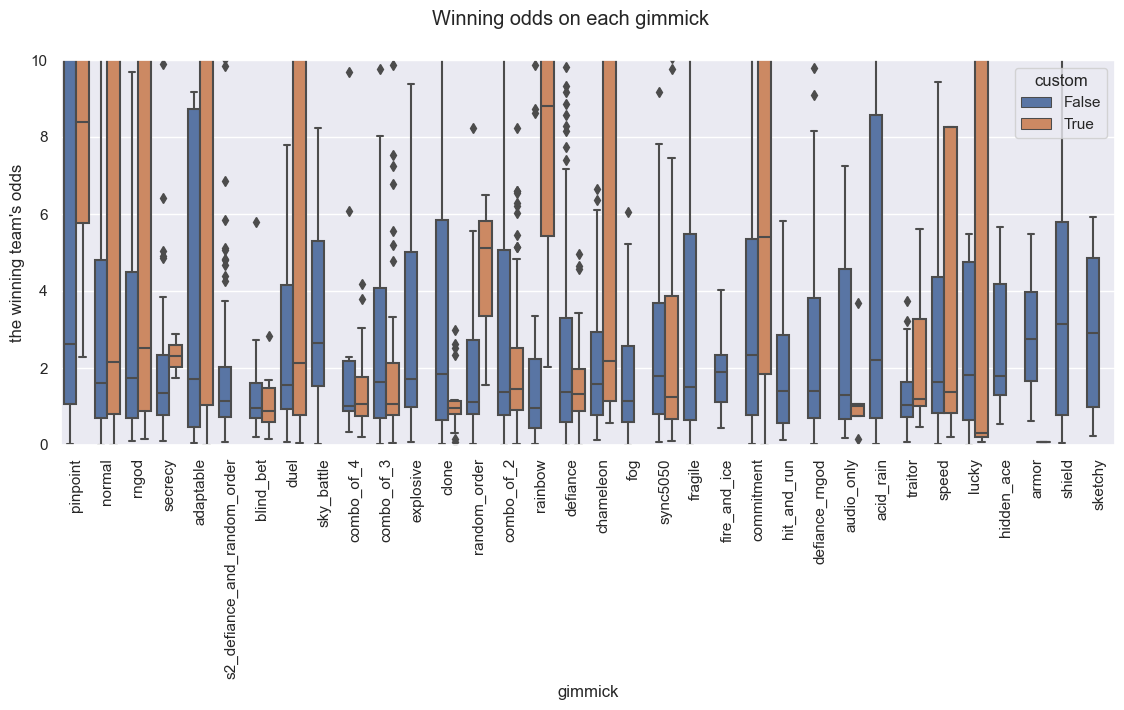

In [23]:
if "gimmick" in keys:
    f = plt.figure(figsize=(len(gim.gimmick.unique())/2.5,5))
    f.suptitle("Winning odds on each gimmick")
    ax = sns.boxplot(x=gim.gimmick,y=gim.winner_odds, hue=gim.custom)
    ax.set(ylabel="the winning team's odds", ylim=(0,10))
    plt.xticks(rotation=90)
    plt.show()